In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv


---
#### 항공 사진내 선인장 식별 - Baseline Model 
- Kaggle notebook 사용 (w/P100)
- 작업순서
  1) 시드값 고정 및 GPU 장비 설정
  2) 데이터 준비 (훈련/검증 데이터 분리, 데이터셋 클래스 정의, 데이터셋 생성, 데이터 로더 생성)
  3) 모델 생성
  4) 모델 훈련 (손실함수, 옵티마이저 설정, 모델 훈련)
  5) 성능 검증
  6) 예측 및 제출
---

In [3]:
# 시드고정 : 머신러닝에서의 random_state와 같은 역할로, pytorch 딥러닝 모델링에서는 맨 처음에 고정
# 결과를 재현할 필요가 없다면 시드값 고장은 생략 (성능&속도 저하됨)
import torch 
import random
import numpy as np
import os

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

In [4]:
# GPU setting 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# 데이터 로딩 
import pandas as pd

data_path = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

print(labels.shape, submission.shape)
labels.head()

(17500, 2) (4000, 2)


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
# 이미지 압축 해제 
from zipfile import ZipFile

with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()

with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

# 이미지 갯수 확인 
import os
print(len(os.listdir('train/')))
print(len(os.listdir('test/')))

17500
4000


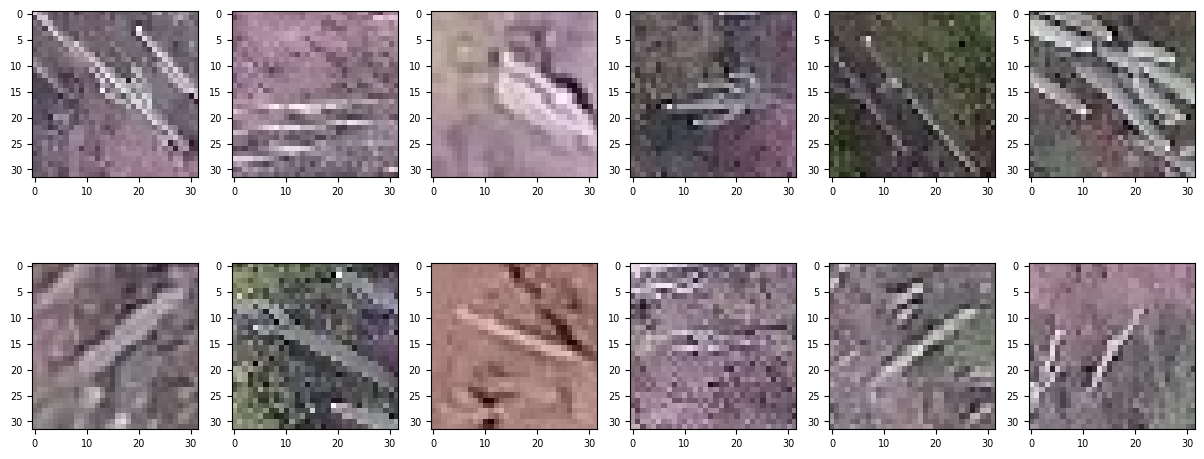

In [7]:
# 샘플이미지 확인 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력)

# 선인장을 포함하는 이미지 파일명(마지막 12개) 
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name                 # 이미지 파일 경로 
    image = cv2.imread(img_path)                   # 이미지 파일 읽기 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력 

In [8]:
# 이미지 구조 확인 
image.shape

(32, 32, 3)

- 가로, 세로 크기가 32 x 32, 채널 수가 3개인 것을 알 수 있다.
- R,G,B로 이루어진 컬러 이미지이기에 채널이 3개이다.

In [9]:
# 훈련, 검증 데이터 분리 
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

print(train.shape, valid.shape)

(15750, 2) (1750, 2)


In [10]:
# Dataset 클래스를 활용해 데이터셋 객체를 만든다. 
# 데이터셋의 크기를 반환하는 메서드와 인덱스에 해당하는 데이터를 반환해주는 메서드를 만들어준다.
from torch.utils.data import Dataset 

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [11]:
# mageDataset 클래스를 이용해 데이터셋을 만든다 
# pytorch 모델로 이미지를 다루려면 이미지 데이터를 Tensor 타입으로 바꾸어야 한다.
from torchvision import transforms # 이미지 변환을 위한 모듈
transform = transforms.ToTensor()

# 앞에서 정의한 ImageDataset() 클래스를 사용해 훈련, 검증 데이터셋을 만든다.
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform)

# 데이터 로더는 지정한 배치 크기만큼 데이터를 불러오는 개체
# 배치 크기는 2의 제곱수로 설정하는게 효율적이다. 
# 배치 크기가 작으면 규제 효과가 있어 일반화 성능이 좋아지지만 훈련 시간이 길어진다.
from torch.utils.data import DataLoader 

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [12]:
# CNN modeling : nn.Module을 상속해 정의 -> 순전파 후 결과를 반환하는 forward()를 재정의
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의 
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출

        # 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, padding=2) 
        # 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, padding=2) 
        # 최대 풀링 계층 
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=2) 
        # 전결합 계층 
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # 평탄화
        x = self.fc(x)
        return x

In [13]:
# device 장비에 할당
model = Model().to(device)
print(model) 

# 손실함수와 옵티마이저 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


#### 모델훈련 절차 
    1) 데이터 로더에서 배치 크기만큼 데이터를 불러온다.
    2) 불러온 이미지 데이터와 레이블(타깃값) 데이터를 장비에 할당한다.
    3) 옵티마이저 내 기울기를 초기화한다.
    4) 신경망 모델에 입력 데이터(이미지)를 전달해 순전파하여 출력값(예측값)을 구한다.
    5) 예측값과 실제 레이블(타깃값)을 비교해 손실을 계산한다.
    6) 손실을 기반으로 역전파를 수행한다.
    7) 역전파로 구한 기울기를 활용해 가중치를 갱신한다.
    8) 1~7 절차를 반복횟수만큼 되풀이한다.
    9) 1~8 절차를 에폭만큼 반복한다.

In [14]:
# 모델 훈련 
epochs = 10 # 총 에폭
# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화

    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()

    # 훈련 데이터 손실값 출력
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss/len(loader_train):.4f}')

Epoch [1/10] - Loss: 0.5233
Epoch [2/10] - Loss: 0.3453
Epoch [3/10] - Loss: 0.2370
Epoch [4/10] - Loss: 0.1984
Epoch [5/10] - Loss: 0.1754
Epoch [6/10] - Loss: 0.1666
Epoch [7/10] - Loss: 0.1545
Epoch [8/10] - Loss: 0.1439
Epoch [9/10] - Loss: 0.1333
Epoch [10/10] - Loss: 0.1299


In [15]:
# 훈련이 끝난 후 valid data로 평가지표인 ROC AUC 값을 구한다.
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device) 

        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률  
        true = labels.cpu() # 실제값 
        # 예측 확률과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 ROC AUC : 0.9902


[참고] 예측 확률을 구하는 outputs.cpu()와 labels.cpu()는 이전에 GPU에 할당했던 outputs, labels 데이터를 다시 CPU에 할당하는 것이다. roc_auc_score()는 pytorch가 아니라 scikitlearn 함수라 gpu에 있는 데이터를 직접 사용하지 못해 바꾸어주는 것이다.

In [16]:
# 예측값 계산 및 결과제출 
# test data를 담은 데이터셋과 데이터 로더를 만들어준다. 배치크기는 32
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [17]:
# test data에서 타깃값이 1일 확률을 예측
# test data에는 타깃값이 없어 for 문에 labels 변수를 할당하지 않았다. 
# tolist()를 호출해 tensor를 list 타입으로 변경해 최종 제출 할 수 있게끔 해준다.

model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)

        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [18]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

In [19]:
submission

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.981365
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999927
2,001ee6d8564003107853118ab87df407.jpg,0.090483
3,002e175c3c1e060769475f52182583d0.jpg,0.102169
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.874402
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.996117
3996,ffae37344310a1549162493237d25d3f.jpg,0.999980
3997,ffbd469c56873d064326204aac546e0d.jpg,0.999386
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.992440


In [20]:
# 사용완료한 폴더와 데이터 삭세 
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')